The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


2023-12-07 19:56:01.088564: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


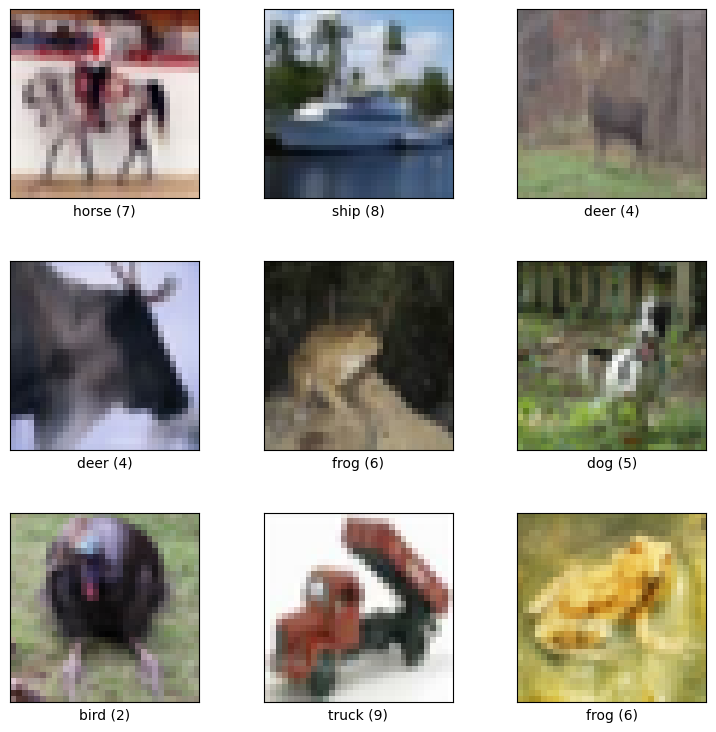

In [2]:
# homework 3 CIFAR-10 dataset and CNN
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import datetime
from tensorflow.core.util import event_pb2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

%load_ext tensorboard
# load the CIFAR-10 dataset
ds, info = tfds.load('cifar10', split=['train', 'test'], with_info=True, as_supervised=True)
# visualize a few images
fig = tfds.show_examples(ds[0], info)


In [3]:
# preprocessing function
def preprocess(img, lable):
    img = tf.cast(img, tf.float32)
    img = (img/128) - 1
    lable = tf.one_hot(lable, 10)
    return img, lable

# data pipeline
def data_pipeline(data, batch_size=64, shuffle_buffer=1000, prefetch_buffer=2):
    data = data.map(lambda img, lable: preprocess(img, lable))
    data = data.shuffle(shuffle_buffer).batch(batch_size).prefetch(prefetch_buffer)
    return data


In [4]:
# basic CNN model
class CNN(tf.keras.Model):
    def __init__(self, layers_config, learning_rate=0.001, optimizer='adam'):
        super().__init__()

        if optimizer == 'adam':
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer == 'sgd':
            self.optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

        self.metrics_list = [
            tf.keras.metrics.Mean(name="loss"),
            tf.keras.metrics.CategoricalAccuracy(name="acc"),
            tf.keras.metrics.TopKCategoricalAccuracy(k=5, name="top5_acc")
        ]

        self.loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

        self.layer_list = []
        for layer_config in layers_config:
            if layer_config['type'] == 'conv':
                self.layer_list.append(tf.keras.layers.Conv2D(**layer_config['params']))
            elif layer_config['type'] == 'pool':
                self.layer_list.append(tf.keras.layers.MaxPool2D(**layer_config['params']))
            elif layer_config['type'] == 'global_pool':
                self.layer_list.append(tf.keras.layers.GlobalAveragePooling2D())
            elif layer_config['type'] == 'dense':
                self.layer_list.append(tf.keras.layers.Dense(**layer_config['params']))

    def call(self, x, training=False):
        for layer in self.layer_list:
            x = layer(x)
        return x
    
    def reset_metrics(self):
        for metric in self.metrics_list:
            metric.reset_states()

    @tf.function
    def train_step(self, data):
        x, targets = data

        with tf.GradientTape() as tape:
            predictions = self(x, training=True)
            loss = self.loss_function(targets, predictions) 

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        #update loss metric
        self.metrics[0].update_state(loss)

        # for all metrics except loss, update them
        for metric in self.metrics[1:]:
            metric.update_state(targets, predictions)
        
        # return a dict mapping metric names to current value
        return {metric.name: metric.result() for metric in self.metrics}
    
    @tf.function
    def test_step(self, data):
        x, targets = data

        predictions = self(x, training=False)
        loss = self.loss_function(targets, predictions)

        # update loss metric
        self.metrics[0].update_state(loss)

        # for all metrics except loss, update them
        for metric in self.metrics[1:]:
            metric.update_state(targets, predictions)
        
        # return a dict mapping metric names to current value
        return {metric.name: metric.result() for metric in self.metrics}

In [5]:
import pprint
import tqdm

def training_loop(model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer):
    for epoch in range(epochs):
        print(f"Epoch {epoch}:")
        
        # Training:
        
        for data in tqdm.tqdm(train_ds, position=0, leave=True):
            metrics = model.train_step(data)
            
            # logging the validation metrics to the log file which is used by tensorboard
            with train_summary_writer.as_default():
                for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        # print the metrics
        print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # reset all metrics (requires a reset_metrics method in the model)
        model.reset_metrics()    
        
        # Validation:
        for data in test_ds:
            metrics = model.test_step(data)
        
            # logging the validation metrics to the log file which is used by tensorboard
            with test_summary_writer.as_default():
                for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
                    
        print([f"test_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # reset all metrics
        model.reset_metrics()
        print("\n")

In [6]:
# this cell uses the tensorboard scalars and plots the loss and accuracy
def process_log(file_path):
    dataset = tf.data.TFRecordDataset(file_path)
    steps = []
    losses = []
    accs = []
    for record in dataset:
        event = event_pb2.Event.FromString(record.numpy())
        for value in event.summary.value:
            if value.tag == 'loss':
                steps.append(event.step)
                loss_value = tf.make_ndarray(value.tensor).item()
                losses.append(loss_value)
            elif value.tag == 'acc':
                acc_value = tf.make_ndarray(value.tensor).item()
                accs.append(acc_value)
    return pd.DataFrame({'Step': steps, 'loss': losses, 'acc': accs})

def plot_results(train_data, test_data, plot_path, config):
    # Add a 'Type' column to distinguish between training and testing data
    train_data['Type'] = 'Train'
    test_data['Type'] = 'Test'

    # Concatenate the training and testing data
    data = pd.concat([train_data, test_data])

    # Melt the data into a long format
    data_long = data.melt(id_vars=['Step', 'Type'], value_vars=['loss', 'acc'], var_name='Metric', value_name='Value')

    # Create a larger figure
    plt.figure(figsize=(10, 6))

    # Plot the data
    sns.lineplot(x='Step', y='Value', hue='Type', style='Metric', data=data_long)

    # Add a title and labels
    plt.title('Training and Testing Loss and Accuracy')
    plt.xlabel('Step')
    plt.ylabel('Value')

    # Add a grid
    plt.grid(True)

    # Move the legend to the upper right corner
    legend = plt.legend(loc='upper right')

    # Add a text box with the model configurations
    config_text = '\n'.join([f'{key}: {value}' for key, value in config.items()])
    plt.text(0.85, 0.95, config_text, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5), 
             horizontalalignment='right', verticalalignment='top')

    # Save the plot
    plt.savefig(plot_path)
    
    plt.show()

Epoch 0:


100%|██████████| 391/391 [00:18<00:00, 21.14it/s]


['loss: 1.6973552703857422', 'acc: 0.35249999165534973', 'top5_acc: 0.853600025177002']
['test_loss: 1.3355296850204468', 'test_acc: 0.5019000172615051', 'test_top5_acc: 0.9409999847412109']


Epoch 1:


100%|██████████| 391/391 [00:14<00:00, 27.20it/s]


['loss: 1.1556216478347778', 'acc: 0.5756199955940247', 'top5_acc: 0.9548400044441223']
['test_loss: 1.0677796602249146', 'test_acc: 0.6198999881744385', 'test_top5_acc: 0.9596999883651733']


Epoch 2:


100%|██████████| 391/391 [00:14<00:00, 27.86it/s]


['loss: 0.8982331156730652', 'acc: 0.678820013999939', 'top5_acc: 0.9736800193786621']
['test_loss: 0.8578777313232422', 'test_acc: 0.6959999799728394', 'test_top5_acc: 0.9754999876022339']


Epoch 3:


100%|██████████| 391/391 [00:14<00:00, 27.73it/s]


['loss: 0.7274816036224365', 'acc: 0.7419599890708923', 'top5_acc: 0.9836400151252747']
['test_loss: 0.7674340605735779', 'test_acc: 0.7412999868392944', 'test_top5_acc: 0.9800999760627747']


Epoch 4:


100%|██████████| 391/391 [00:14<00:00, 27.60it/s]


['loss: 0.6141105890274048', 'acc: 0.7842400074005127', 'top5_acc: 0.9877200126647949']
['test_loss: 0.7353419065475464', 'test_acc: 0.7513999938964844', 'test_top5_acc: 0.9807999730110168']


Epoch 5:


100%|██████████| 391/391 [00:14<00:00, 27.45it/s]


['loss: 0.5145253539085388', 'acc: 0.8197799921035767', 'top5_acc: 0.9916200041770935']
['test_loss: 0.7040853500366211', 'test_acc: 0.7692000269889832', 'test_top5_acc: 0.9855999946594238']


Epoch 6:


100%|██████████| 391/391 [00:14<00:00, 27.47it/s]


['loss: 0.43976160883903503', 'acc: 0.8468800187110901', 'top5_acc: 0.9934599995613098']
['test_loss: 0.7181143760681152', 'test_acc: 0.7749999761581421', 'test_top5_acc: 0.9847999811172485']


Epoch 7:


100%|██████████| 391/391 [00:14<00:00, 27.59it/s]


['loss: 0.3739275634288788', 'acc: 0.8679199814796448', 'top5_acc: 0.9955999851226807']
['test_loss: 0.7486075758934021', 'test_acc: 0.7839999794960022', 'test_top5_acc: 0.9865999817848206']


Epoch 8:


100%|██████████| 391/391 [00:14<00:00, 27.57it/s]


['loss: 0.3099992573261261', 'acc: 0.8906000256538391', 'top5_acc: 0.9969199895858765']
['test_loss: 0.7952040433883667', 'test_acc: 0.7724999785423279', 'test_top5_acc: 0.984499990940094']


Epoch 9:


100%|██████████| 391/391 [00:14<00:00, 27.45it/s]


['loss: 0.25396788120269775', 'acc: 0.9117799997329712', 'top5_acc: 0.997979998588562']
['test_loss: 0.8121346831321716', 'test_acc: 0.7748000025749207', 'test_top5_acc: 0.9847000241279602']


Epoch 10:


100%|██████████| 391/391 [00:14<00:00, 27.63it/s]


['loss: 0.21654221415519714', 'acc: 0.9233199954032898', 'top5_acc: 0.9988800287246704']
['test_loss: 0.9111158847808838', 'test_acc: 0.7797999978065491', 'test_top5_acc: 0.984499990940094']


Epoch 11:


100%|██████████| 391/391 [00:14<00:00, 27.53it/s]


['loss: 0.19810491800308228', 'acc: 0.9296200275421143', 'top5_acc: 0.9990800023078918']
['test_loss: 0.8271238803863525', 'test_acc: 0.7759000062942505', 'test_top5_acc: 0.982699990272522']


Epoch 12:


100%|██████████| 391/391 [00:14<00:00, 27.59it/s]


['loss: 0.16671356558799744', 'acc: 0.9408000111579895', 'top5_acc: 0.9993600249290466']
['test_loss: 0.9582577347755432', 'test_acc: 0.7720999717712402', 'test_top5_acc: 0.9836999773979187']


Epoch 13:


100%|██████████| 391/391 [00:14<00:00, 27.40it/s]


['loss: 0.13602517545223236', 'acc: 0.9530799984931946', 'top5_acc: 0.9995200037956238']
['test_loss: 1.067360520362854', 'test_acc: 0.7750999927520752', 'test_top5_acc: 0.9833999872207642']


Epoch 14:


100%|██████████| 391/391 [00:14<00:00, 27.43it/s]


['loss: 0.1328955888748169', 'acc: 0.9546599984169006', 'top5_acc: 0.9996600151062012']
['test_loss: 0.9865877032279968', 'test_acc: 0.7885000109672546', 'test_top5_acc: 0.9846000075340271']




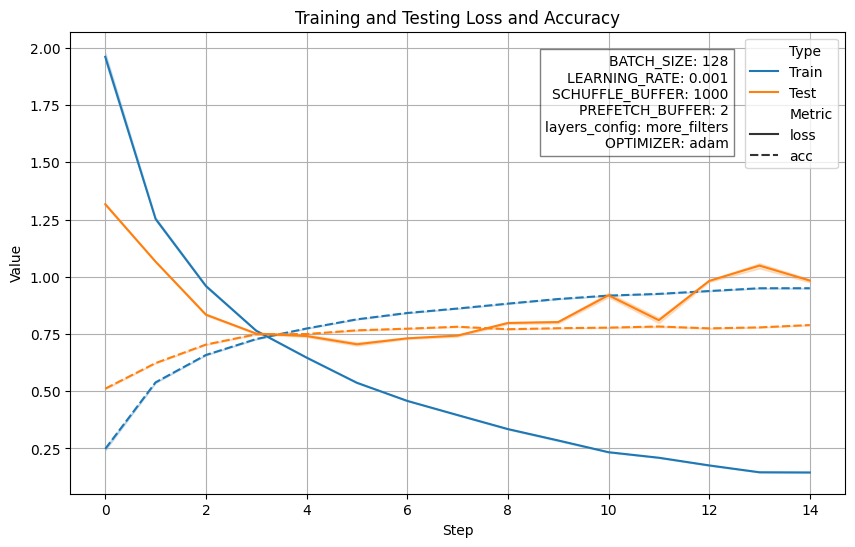

Epoch 0:


100%|██████████| 1563/1563 [00:33<00:00, 46.39it/s]


['loss: 1.610995888710022', 'acc: 0.38405999541282654', 'top5_acc: 0.881879985332489']
['test_loss: 1.2599149942398071', 'test_acc: 0.5327000021934509', 'test_top5_acc: 0.942799985408783']


Epoch 1:


100%|██████████| 1563/1563 [00:30<00:00, 51.49it/s]


['loss: 1.0913572311401367', 'acc: 0.6039599776268005', 'top5_acc: 0.958840012550354']
['test_loss: 0.9922794699668884', 'test_acc: 0.646399974822998', 'test_top5_acc: 0.9638000130653381']


Epoch 2:


100%|██████████| 1563/1563 [00:30<00:00, 51.03it/s]


['loss: 0.84212327003479', 'acc: 0.7026399970054626', 'top5_acc: 0.9760400056838989']
['test_loss: 0.8039966821670532', 'test_acc: 0.7261999845504761', 'test_top5_acc: 0.9778000116348267']


Epoch 3:


100%|██████████| 1563/1563 [00:31<00:00, 50.29it/s]


['loss: 0.6965808272361755', 'acc: 0.7548400163650513', 'top5_acc: 0.9837200045585632']
['test_loss: 0.7739964723587036', 'test_acc: 0.7451000213623047', 'test_top5_acc: 0.9810000061988831']


Epoch 4:


100%|██████████| 1563/1563 [00:31<00:00, 49.98it/s]


['loss: 0.5792409181594849', 'acc: 0.7990000247955322', 'top5_acc: 0.9890599846839905']
['test_loss: 0.7542441487312317', 'test_acc: 0.7549999952316284', 'test_top5_acc: 0.9825000166893005']


Epoch 5:


100%|██████████| 1563/1563 [00:31<00:00, 49.26it/s]


['loss: 0.49183422327041626', 'acc: 0.8275200128555298', 'top5_acc: 0.9925000071525574']
['test_loss: 0.7529948949813843', 'test_acc: 0.7638000249862671', 'test_top5_acc: 0.9829999804496765']


Epoch 6:


100%|██████████| 1563/1563 [00:32<00:00, 48.75it/s]


['loss: 0.41527247428894043', 'acc: 0.8539000153541565', 'top5_acc: 0.9943000078201294']
['test_loss: 0.7853731513023376', 'test_acc: 0.7720999717712402', 'test_top5_acc: 0.983299970626831']


Epoch 7:


100%|██████████| 1563/1563 [00:33<00:00, 47.23it/s]


['loss: 0.35604095458984375', 'acc: 0.8737000226974487', 'top5_acc: 0.9962999820709229']
['test_loss: 0.868765652179718', 'test_acc: 0.7605999708175659', 'test_top5_acc: 0.9815000295639038']


Epoch 8:


100%|██████████| 1563/1563 [00:34<00:00, 45.59it/s]


['loss: 0.3144923448562622', 'acc: 0.8875600099563599', 'top5_acc: 0.9974799752235413']
['test_loss: 0.9041218757629395', 'test_acc: 0.7615000009536743', 'test_top5_acc: 0.9779999852180481']


Epoch 9:


100%|██████████| 1563/1563 [00:35<00:00, 44.40it/s]


['loss: 0.2666134238243103', 'acc: 0.9043400287628174', 'top5_acc: 0.9984599947929382']
['test_loss: 0.9793654084205627', 'test_acc: 0.7555999755859375', 'test_top5_acc: 0.9782000184059143']


Epoch 10:


100%|██████████| 1563/1563 [00:36<00:00, 42.32it/s]


['loss: 0.2392498403787613', 'acc: 0.9153599739074707', 'top5_acc: 0.9986400008201599']
['test_loss: 1.0633115768432617', 'test_acc: 0.7534000277519226', 'test_top5_acc: 0.9769999980926514']


Epoch 11:


100%|██████████| 1563/1563 [00:36<00:00, 43.07it/s]


['loss: 0.21026964485645294', 'acc: 0.9254599809646606', 'top5_acc: 0.999180018901825']
['test_loss: 1.0227916240692139', 'test_acc: 0.7559999823570251', 'test_top5_acc: 0.9785000085830688']


Epoch 12:


100%|██████████| 1563/1563 [00:36<00:00, 42.76it/s]


['loss: 0.19325773417949677', 'acc: 0.9328799843788147', 'top5_acc: 0.9991999864578247']
['test_loss: 1.0579020977020264', 'test_acc: 0.7664999961853027', 'test_top5_acc: 0.9782999753952026']


Epoch 13:


100%|██████████| 1563/1563 [00:36<00:00, 42.99it/s]


['loss: 0.1799541711807251', 'acc: 0.9377599954605103', 'top5_acc: 0.9994199872016907']
['test_loss: 1.2181669473648071', 'test_acc: 0.7502999901771545', 'test_top5_acc: 0.9753000140190125']


Epoch 14:


100%|██████████| 1563/1563 [00:36<00:00, 42.51it/s]


['loss: 0.170547217130661', 'acc: 0.9414799809455872', 'top5_acc: 0.9994000196456909']
['test_loss: 1.1093815565109253', 'test_acc: 0.767799973487854', 'test_top5_acc: 0.9800999760627747']




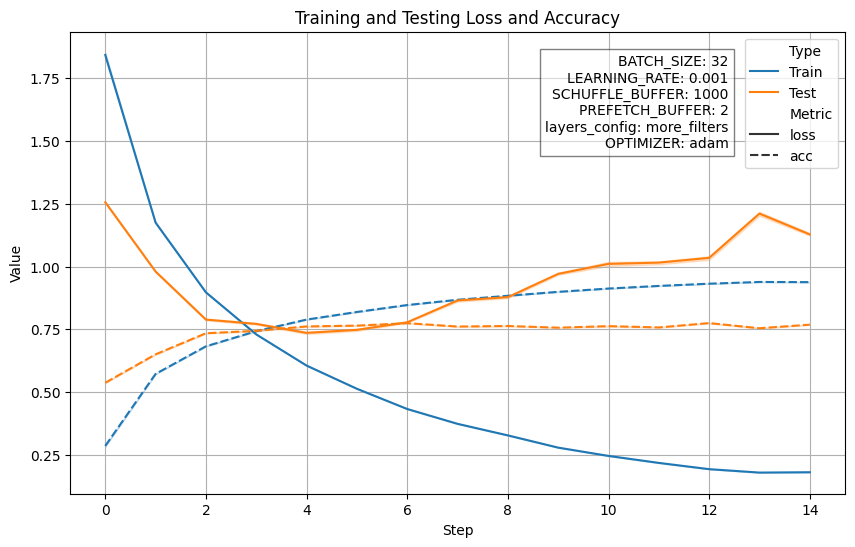

Epoch 0:


100%|██████████| 782/782 [00:27<00:00, 28.33it/s]


['loss: 1.589368224143982', 'acc: 0.39706000685691833', 'top5_acc: 0.8835600018501282']
['test_loss: 1.1952333450317383', 'test_acc: 0.5523999929428101', 'test_top5_acc: 0.9524000287055969']


Epoch 1:


100%|██████████| 782/782 [00:21<00:00, 35.63it/s]


['loss: 1.076584815979004', 'acc: 0.6081399917602539', 'top5_acc: 0.9594799876213074']
['test_loss: 0.9463071227073669', 'test_acc: 0.6751000285148621', 'test_top5_acc: 0.9714000225067139']


Epoch 2:


100%|██████████| 782/782 [00:21<00:00, 35.60it/s]


['loss: 0.8184109926223755', 'acc: 0.7109400033950806', 'top5_acc: 0.977400004863739']
['test_loss: 0.7886379957199097', 'test_acc: 0.729200005531311', 'test_top5_acc: 0.9789000153541565']


Epoch 3:


100%|██████████| 782/782 [00:21<00:00, 35.85it/s]


['loss: 0.6576309204101562', 'acc: 0.7709400057792664', 'top5_acc: 0.9855800271034241']
['test_loss: 0.7108902931213379', 'test_acc: 0.7613999843597412', 'test_top5_acc: 0.982699990272522']


Epoch 4:


100%|██████████| 782/782 [00:21<00:00, 35.66it/s]


['loss: 0.5409502387046814', 'acc: 0.8108400106430054', 'top5_acc: 0.9902399778366089']
['test_loss: 0.6781319379806519', 'test_acc: 0.7709000110626221', 'test_top5_acc: 0.9835000038146973']


Epoch 5:


100%|██████████| 782/782 [00:21<00:00, 35.59it/s]


['loss: 0.451632559299469', 'acc: 0.8410400152206421', 'top5_acc: 0.9939200282096863']
['test_loss: 0.6869016289710999', 'test_acc: 0.7775999903678894', 'test_top5_acc: 0.9818999767303467']


Epoch 6:


100%|██████████| 782/782 [00:21<00:00, 35.60it/s]


['loss: 0.37282490730285645', 'acc: 0.8696600198745728', 'top5_acc: 0.9956600069999695']
['test_loss: 0.7177754044532776', 'test_acc: 0.7896999716758728', 'test_top5_acc: 0.9851999878883362']


Epoch 7:


100%|██████████| 782/782 [00:21<00:00, 35.57it/s]


['loss: 0.30938297510147095', 'acc: 0.8908200263977051', 'top5_acc: 0.9976000189781189']
['test_loss: 0.7719377875328064', 'test_acc: 0.7784000039100647', 'test_top5_acc: 0.9835000038146973']


Epoch 8:


100%|██████████| 782/782 [00:22<00:00, 35.43it/s]


['loss: 0.2571520209312439', 'acc: 0.9087399840354919', 'top5_acc: 0.998420000076294']
['test_loss: 0.8381048440933228', 'test_acc: 0.7871999740600586', 'test_top5_acc: 0.984499990940094']


Epoch 9:


100%|██████████| 782/782 [00:21<00:00, 35.65it/s]


['loss: 0.21567991375923157', 'acc: 0.9232199788093567', 'top5_acc: 0.9991199970245361']
['test_loss: 0.8797844648361206', 'test_acc: 0.7825000286102295', 'test_top5_acc: 0.9853000044822693']


Epoch 10:


100%|██████████| 782/782 [00:22<00:00, 35.49it/s]


['loss: 0.18474288284778595', 'acc: 0.9354000091552734', 'top5_acc: 0.9991999864578247']
['test_loss: 0.8962793946266174', 'test_acc: 0.7940000295639038', 'test_top5_acc: 0.9815999865531921']


Epoch 11:


100%|██████████| 782/782 [00:22<00:00, 35.34it/s]


['loss: 0.16088391840457916', 'acc: 0.9427199959754944', 'top5_acc: 0.9994800090789795']
['test_loss: 0.9903196096420288', 'test_acc: 0.7809000015258789', 'test_top5_acc: 0.9815000295639038']


Epoch 12:


100%|██████████| 782/782 [00:22<00:00, 34.41it/s]


['loss: 0.13928630948066711', 'acc: 0.9505400061607361', 'top5_acc: 0.9997599720954895']
['test_loss: 1.0517164468765259', 'test_acc: 0.7821999788284302', 'test_top5_acc: 0.9824000000953674']


Epoch 13:


100%|██████████| 782/782 [00:21<00:00, 35.68it/s]


['loss: 0.12898817658424377', 'acc: 0.9549400210380554', 'top5_acc: 0.999779999256134']
['test_loss: 1.0701667070388794', 'test_acc: 0.7793999910354614', 'test_top5_acc: 0.9804999828338623']


Epoch 14:


100%|██████████| 782/782 [00:22<00:00, 35.18it/s]


['loss: 0.1227041557431221', 'acc: 0.9587200284004211', 'top5_acc: 0.9996399879455566']
['test_loss: 1.109816312789917', 'test_acc: 0.7804999947547913', 'test_top5_acc: 0.9789999723434448']




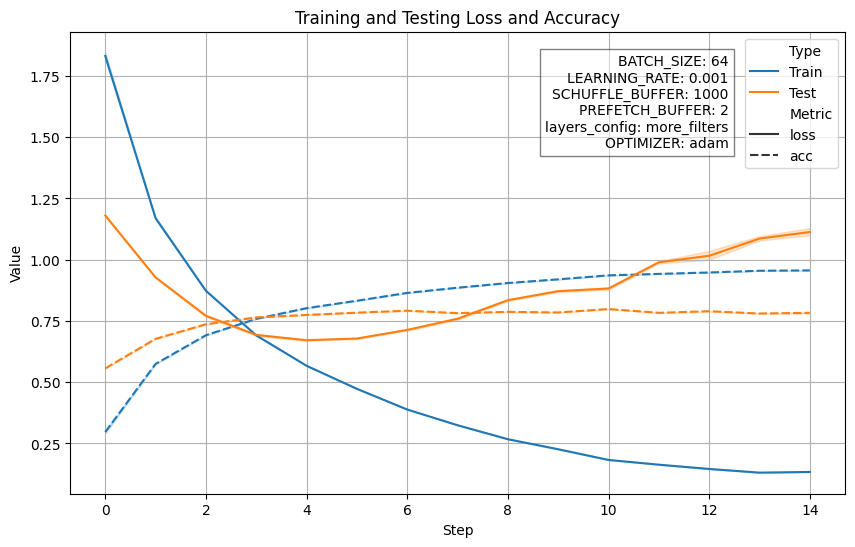

Epoch 0:


100%|██████████| 391/391 [00:18<00:00, 20.74it/s]


['loss: 1.6629531383514404', 'acc: 0.3646399974822998', 'top5_acc: 0.8691200017929077']
['test_loss: 1.342981219291687', 'test_acc: 0.5088000297546387', 'test_top5_acc: 0.9394000172615051']


Epoch 1:


100%|██████████| 391/391 [00:15<00:00, 25.65it/s]


['loss: 1.1484323740005493', 'acc: 0.5795999765396118', 'top5_acc: 0.9559999704360962']
['test_loss: 1.067313551902771', 'test_acc: 0.6115000247955322', 'test_top5_acc: 0.9657999873161316']


Epoch 2:


100%|██████████| 391/391 [00:15<00:00, 25.40it/s]


['loss: 0.9078589081764221', 'acc: 0.6739000082015991', 'top5_acc: 0.9729400277137756']
['test_loss: 0.8833601474761963', 'test_acc: 0.6869000196456909', 'test_top5_acc: 0.9771999716758728']


Epoch 3:


100%|██████████| 391/391 [00:15<00:00, 25.45it/s]


['loss: 0.7405751347541809', 'acc: 0.7375400066375732', 'top5_acc: 0.9814800024032593']
['test_loss: 0.7383474111557007', 'test_acc: 0.7409999966621399', 'test_top5_acc: 0.9819999933242798']


Epoch 4:


100%|██████████| 391/391 [00:15<00:00, 25.49it/s]


['loss: 0.6117459535598755', 'acc: 0.7861400246620178', 'top5_acc: 0.9869999885559082']
['test_loss: 0.7393350601196289', 'test_acc: 0.7552000284194946', 'test_top5_acc: 0.9811999797821045']


Epoch 5:


100%|██████████| 391/391 [00:15<00:00, 25.65it/s]


['loss: 0.5092628002166748', 'acc: 0.8217999935150146', 'top5_acc: 0.9908000230789185']
['test_loss: 0.694401741027832', 'test_acc: 0.7710000276565552', 'test_top5_acc: 0.9853000044822693']


Epoch 6:


100%|██████████| 391/391 [00:15<00:00, 25.16it/s]


['loss: 0.43158379197120667', 'acc: 0.8497200012207031', 'top5_acc: 0.9934200048446655']
['test_loss: 0.7653813362121582', 'test_acc: 0.765999972820282', 'test_top5_acc: 0.9825999736785889']


Epoch 7:


100%|██████████| 391/391 [00:15<00:00, 25.40it/s]


['loss: 0.3675938546657562', 'acc: 0.8704400062561035', 'top5_acc: 0.9955400228500366']
['test_loss: 0.7361919283866882', 'test_acc: 0.7724999785423279', 'test_top5_acc: 0.984000027179718']


Epoch 8:


100%|██████████| 391/391 [00:15<00:00, 25.51it/s]


['loss: 0.2968340516090393', 'acc: 0.8961799740791321', 'top5_acc: 0.9970600008964539']
['test_loss: 0.81717449426651', 'test_acc: 0.7633000016212463', 'test_top5_acc: 0.9778000116348267']


Epoch 9:


100%|██████████| 391/391 [00:15<00:00, 25.60it/s]


['loss: 0.2385227233171463', 'acc: 0.9167799949645996', 'top5_acc: 0.9982799887657166']
['test_loss: 0.8755370378494263', 'test_acc: 0.7670999765396118', 'test_top5_acc: 0.9836999773979187']


Epoch 10:


100%|██████████| 391/391 [00:15<00:00, 25.23it/s]


['loss: 0.20225192606449127', 'acc: 0.9275199770927429', 'top5_acc: 0.9990400075912476']
['test_loss: 0.8225152492523193', 'test_acc: 0.7757999897003174', 'test_top5_acc: 0.9853000044822693']


Epoch 11:


100%|██████████| 391/391 [00:15<00:00, 25.49it/s]


['loss: 0.17603257298469543', 'acc: 0.9375600218772888', 'top5_acc: 0.9993000030517578']
['test_loss: 0.8725685477256775', 'test_acc: 0.7857999801635742', 'test_top5_acc: 0.9861999750137329']


Epoch 12:


100%|██████████| 391/391 [00:15<00:00, 25.84it/s]


['loss: 0.15204110741615295', 'acc: 0.9464399814605713', 'top5_acc: 0.9996399879455566']
['test_loss: 1.0792204141616821', 'test_acc: 0.7734000086784363', 'test_top5_acc: 0.9847000241279602']


Epoch 13:


100%|██████████| 391/391 [00:15<00:00, 25.76it/s]


['loss: 0.13022874295711517', 'acc: 0.9554799795150757', 'top5_acc: 0.9997400045394897']
['test_loss: 0.9199562668800354', 'test_acc: 0.7860999703407288', 'test_top5_acc: 0.9847999811172485']


Epoch 14:


100%|██████████| 391/391 [00:15<00:00, 25.65it/s]


['loss: 0.11352111399173737', 'acc: 0.9596800208091736', 'top5_acc: 0.9998199939727783']
['test_loss: 1.015032172203064', 'test_acc: 0.7832000255584717', 'test_top5_acc: 0.9837999939918518']




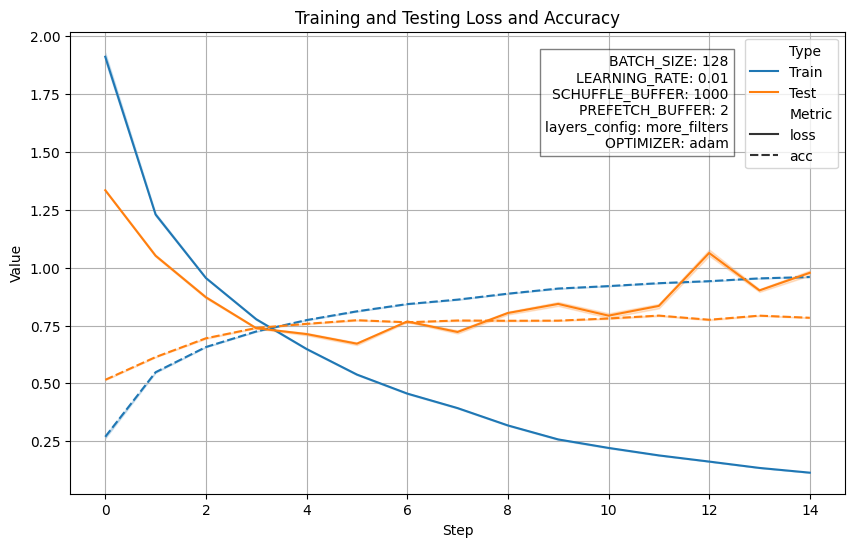

In [8]:
# prepair training and testing data
train_ds = ds[0]
test_ds = ds[1]

# instantiate the model
layers_config_normal = [
    {'type': 'conv', 'params': {'filters': 32, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'}},
    {'type': 'conv', 'params': {'filters': 32, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'}},
    {'type': 'pool', 'params': {'pool_size': (2, 2), 'strides': (2, 2)}},
    {'type': 'conv', 'params': {'filters': 64, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'}},
    {'type': 'conv', 'params': {'filters': 64, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'}},
    {'type': 'pool', 'params': {'pool_size': (2, 2), 'strides': (2, 2)}},
    {'type': 'conv', 'params': {'filters': 128, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'}},
    {'type': 'conv', 'params': {'filters': 128, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'}}, 
    {'type': 'global_pool', 'params': {}},
    {'type': 'dense', 'params': {'units': 10, 'activation': 'softmax'}}
]
layers_config_few_filters = [
    {'type': 'conv', 'params': {'filters': 4, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'}},
    {'type': 'conv', 'params': {'filters': 4, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'}},
    {'type': 'pool', 'params': {'pool_size': (2, 2), 'strides': (2, 2)}},
    {'type': 'conv', 'params': {'filters': 8, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'}},
    {'type': 'conv', 'params': {'filters': 8, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'}},
    {'type': 'pool', 'params': {'pool_size': (2, 2), 'strides': (2, 2)}},
    {'type': 'conv', 'params': {'filters': 16, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'}},
    {'type': 'conv', 'params': {'filters': 16, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'}},
    {'type': 'global_pool', 'params': {}},
    {'type': 'dense', 'params': {'units': 10, 'activation': 'softmax'}}
]
layers_config_2 = [
    {'type': 'conv', 'params': {'filters': 32, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'}},
    {'type': 'conv', 'params': {'filters': 32, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'}},
    {'type': 'pool', 'params': {'pool_size': (2, 2), 'strides': (2, 2)}},
    {'type': 'conv', 'params': {'filters': 64, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'}},
    {'type': 'conv', 'params': {'filters': 64, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'}},
    {'type': 'pool', 'params': {'pool_size': (2, 2), 'strides': (2, 2)}},
    {'type': 'conv', 'params': {'filters': 128, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'}},
    {'type': 'conv', 'params': {'filters': 128, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'}},
    {'type': 'pool', 'params': {'pool_size': (2, 2), 'strides': (2, 2)}},
    {'type': 'conv', 'params': {'filters': 256, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'}},
    {'type': 'conv', 'params': {'filters': 256, 'kernel_size': (3, 3), 'padding': 'same', 'activation': 'relu'}},
    {'type': 'global_pool', 'params': {}},
    {'type': 'dense', 'params': {'units': 512, 'activation': 'relu'}},
    {'type': 'dense', 'params': {'units': 10, 'activation': 'softmax'}}
]
    
BATCH_SIZE_1 = 128
BATCH_SIZE_2 = 32
BATCH_SIZE_3 = 64
SCHUFFLE_BUFFER = 1000
PREFETCH_BUFFER = 2
LEARNING_RATE_1 = 0.001
LEARNING_RATE_2 = 0.01
OPTIMIZER_1 = 'adam'
OPTIMIZER_2 = 'sgd'
EPOCHS = 15



hyper_list = [#(BATCH_SIZE_1, LEARNING_RATE_1, SCHUFFLE_BUFFER, PREFETCH_BUFFER, layers_config_normal, OPTIMIZER_1),  # standard model
                #(BATCH_SIZE_1, LEARNING_RATE_2, SCHUFFLE_BUFFER, PREFETCH_BUFFER, layers_config_normal, OPTIMIZER_1),# lower learning rate
                #(BATCH_SIZE_2, LEARNING_RATE_1, SCHUFFLE_BUFFER, PREFETCH_BUFFER, layers_config_normal, OPTIMIZER_1),# lower batch size
                #(BATCH_SIZE_1, LEARNING_RATE_1, SCHUFFLE_BUFFER, PREFETCH_BUFFER, layers_config_few_filters, OPTIMIZER_1),# different architecture with fewer filters
                #(BATCH_SIZE_1, LEARNING_RATE_1, SCHUFFLE_BUFFER, PREFETCH_BUFFER, layers_config_normal, OPTIMIZER_2),# different optimizer
                #(BATCH_SIZE_1, LEARNING_RATE_2, SCHUFFLE_BUFFER, PREFETCH_BUFFER, layers_config_normal, OPTIMIZER_2),# different optimizer and learning rate
                #(BATCH_SIZE_2, LEARNING_RATE_1, SCHUFFLE_BUFFER, PREFETCH_BUFFER, layers_config_few_filters, OPTIMIZER_1),# different architecture with fewer filters and lower batch size
                #(BATCH_SIZE_2, LEARNING_RATE_2, SCHUFFLE_BUFFER, PREFETCH_BUFFER, layers_config_few_filters, OPTIMIZER_2),# different architecture with fewer filters and lower batch size, different optimizer and learning rate
                (BATCH_SIZE_1, LEARNING_RATE_1, SCHUFFLE_BUFFER, PREFETCH_BUFFER, layers_config_2, OPTIMIZER_1),# different architecture with more filters
                (BATCH_SIZE_2, LEARNING_RATE_1, SCHUFFLE_BUFFER, PREFETCH_BUFFER, layers_config_2, OPTIMIZER_1),# different architecture with more filters and lower batch size
                (BATCH_SIZE_3, LEARNING_RATE_1, SCHUFFLE_BUFFER, PREFETCH_BUFFER, layers_config_2, OPTIMIZER_1),# different architecture with more filters and higher batch size
                (BATCH_SIZE_1, LEARNING_RATE_2, SCHUFFLE_BUFFER, PREFETCH_BUFFER, layers_config_2, OPTIMIZER_1)]# different architecture with more filters and lower learning rate
# Define names for each layers_config
layers_config_names = {
    str(layers_config_normal): 'normal_filters',
    str(layers_config_few_filters): 'few_filters',
    str(layers_config_2): 'more_filters'
}
for hyper in hyper_list:
    BATCH_SIZE, LEARNING_RATE, SCHUFFLE_BUFFER, PREFETCH_BUFFER, layers_config, OPTIMIZER = hyper

    # Prepare the data
    train_ds = ds[0]
    test_ds = ds[1]
    train_ds = data_pipeline(train_ds, batch_size=BATCH_SIZE, shuffle_buffer=SCHUFFLE_BUFFER, prefetch_buffer=PREFETCH_BUFFER)
    test_ds = data_pipeline(test_ds, batch_size=BATCH_SIZE, shuffle_buffer=SCHUFFLE_BUFFER, prefetch_buffer=PREFETCH_BUFFER)

    # Instantiate the model
    model = CNN(layers_config)

    # Run model on input once so the layers are built
    model(tf.keras.Input((28,28,3)))

    # Define where to save the log
    layers_config_name = layers_config_names[str(layers_config)]
    config_name = f"config_{BATCH_SIZE}_{LEARNING_RATE}_{OPTIMIZER}_{layers_config_name}"
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    train_log_path = f"logs/{config_name}/{current_time}/train"
    test_log_path = f"logs/{config_name}/{current_time}/test"

    # Log writer for training metrics
    train_summary_writer = tf.summary.create_file_writer(train_log_path)

    # Log writer for test metrics
    test_summary_writer = tf.summary.create_file_writer(test_log_path)

    # Run the training loop 
    training_loop(model=model, 
                  train_ds=train_ds, 
                  test_ds=test_ds, 
                  epochs=EPOCHS, 
                  train_summary_writer=train_summary_writer, 
                  test_summary_writer=test_summary_writer)
    # Process the logs
    # Get a list of all files in the directory
    train_log_files = os.listdir(train_log_path)

    # Assuming there's only one file, get its name
    train_log_file = train_log_files[0]
    train_data = process_log(os.path.join(train_log_path, train_log_file))

    # Get a list of all files in the directory
    test_log_files = os.listdir(test_log_path)

    # Assuming there's only one file, get its name
    test_log_file = test_log_files[0]
    test_data = process_log(os.path.join(test_log_path, test_log_file))

    # Define where to save the plot
    plot_path = f"logs/{config_name}/{current_time}/plot.png"

    # Define your model configurations
    config = {
        'BATCH_SIZE': BATCH_SIZE,
        'LEARNING_RATE': LEARNING_RATE,
        'SCHUFFLE_BUFFER': SCHUFFLE_BUFFER,
        'PREFETCH_BUFFER': PREFETCH_BUFFER,
        'layers_config': layers_config_name,
        'OPTIMIZER': OPTIMIZER
    }

    # Plot the results
    plot_results(train_data, test_data, plot_path, config)


In [9]:
# buffer size 32 vs 128 was a big time difference
%tensorboard --logdir logs/
